# Faulty zero filter

This notebook shows the "FZ_filter" to detect faulty zeros in rainfall time series based on data from neighboring sensors.

The original R code stems from https://github.com/LottedeVos/PWSQC/. The current code is a variation of [this](https://github.com/NiekvanAndel/QC_radar/blob/main/script_1_0.py) Python implementation of the original R code.

The idea of the filter is to evaluate rainfall data of a sensors (in our case here a PWS) in comparison to a reference, which in case of a PWS network stems from neighboring sensors, and flag period where the reference has non-zero rainfall but the data in question is showing zeros for a a minimum number of consecutive time steps.

Below, we use open PWS dataset from Amsterdam, called the "AMS PWS" dataset.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import poligrain as plg
import xarray as xr
import numpy as np

import pypwsqc

## Get AMS PWS data

We use this NetCDF which was prepared for the OPENSENSE training school.

(this will be updated to use an example dataset of `pypwsqc` soon)

In [2]:
#trying with other data set to get the same results
#!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 10.7M    0 16384    0     0   8537      0  0:22:03  0:00:01  0:22:02 17355
  5 10.7M    5  576k    0     0   198k      0  0:00:55  0:00:02  0:00:53  299k
 11 10.7M   11 1264k    0     0   322k      0  0:00:34  0:00:03  0:00:31  429k
 18 10.7M   18 2080k    0     0   424k      0  0:00:25  0:00:04  0:00:21  529k
 25 10.7M   25 2848k    0     0   481k      0  0:00:22  0:00:05  0:00:17  576k
 36 10.7M   36 4064k    0     0   589k      0  0:00:18  0:00:06  0:00:12  813k
 48 10.7M   48 5392k    0     0   682k      0  0:00:16  0:00:07  0:00:09  963k
 63 10.7M   63 6960k    0     0   782k      0  0:0

In [2]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)


In [3]:
ds_pws = ds_pws.sel(time=slice("2017-09-13 00:00", "2017-09-13 03:00"))

In [4]:
max_distance = 5e3 

In [156]:
#THIS IS THE DATASET YOU SHOULD USE!

# read PWS data with xarray
#ds_pws = xr.open_dataset("C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data.nc")

#cut to short period for demo
#ds_pws = ds_pws.sel(time=slice("2017-09-12 18:00:00", "2017-09-13 16:00"))

# view data
#ds_pws

<xarray.Dataset>
Dimensions:    (time: 265, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-09-12T18:00:00 ... 2017-09-13T16:00:00
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 ...
    longitude  (id) float64 ...
Data variables:
    rainfall   (id, time) float32 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.lon, y=ds_pws.lat, target_projection="EPSG:25832"
)

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)


In [7]:
pws_id = "ams2"

neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)
    ] 

neighbor_ids

array(['ams1', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams12'], dtype='<U6')

In [7]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []
reference = []

for pws_id in ds_pws.id.data:
    
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)
    ] 
    
    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)
    
ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
ds_pws["reference"] = xr.concat(reference, dim="id")

CPU times: total: 6.52 s
Wall time: 6.58 s


In [8]:
ds_pws

<xarray.Dataset>
Dimensions:       (time: 37, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-09-13 ... 2017-09-13T03:00:00
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat           (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon           (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.101 0.303 0.202 0.0 ... 0.0 0.0 0.101
    nbrs_not_nan  (id, time) int32 0 0 0 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2
    reference     (id, time) float64 0.101 0.303 0.101 0.0 ... 0.0 0.101 0.0 0.0
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

## Calling flagging.py (current version)

In [10]:
pws_id = "ams2"
neighbor_ids = ['ams1', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9', 'ams12']

#"old" neighbor_ids
#neighbor_ids = ['ams124', 'ams127', 'ams129', 'ams131', 'ams133', 'ams134']

#"old" fz_flag_current
#array([-1., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
#        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
#        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

In [11]:
#ds_pws.sel(id=neighbor_ids)
neighbor_ids

['ams1', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9', 'ams12']

In [12]:
#fz_flag = pypwsqc.flagging.fz_filter(pws_data=ds_pws.rainfall, nbrs_not_nan=ds_pws.nbrs_not_nan, reference=ds_pws.reference, nint = 3)

fz_flag_current = pypwsqc.flagging.fz_filter(
    pws_data=ds_pws.sel(id=pws_id).rainfall,
    reference=ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id"),
    nint=3,
)

In [13]:
neighbor_ids

['ams1', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9', 'ams12']

In [14]:
fz_flag_current

array([-1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

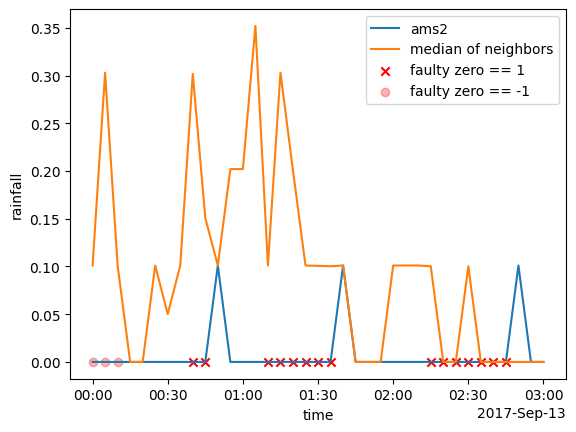

In [15]:
ds_pws.sel(id=pws_id).rainfall.plot(label="ams2")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")

plt.scatter(
    ds_pws.time.where(fz_flag_current == 1),
    fz_flag_current * 0,
    marker="x",
    c="r",
    label="faulty zero == 1",
)
plt.scatter(
    ds_pws.time.where(fz_flag_current == -1),
   fz_flag_current * 0,
    marker="o",
    c="r",
    alpha=0.3,
    label="faulty zero == -1",
)

plt.legend();

In [10]:
#fz_flag = pypwsqc.flagging.fz_filter(
#    pws_data=ds_pws.sel(id=pws_id).rainfall,
#    reference=ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id"),
#    nint=3,
#)

## Placing function in notebook - testing for one station

In [16]:
pws_data_test=ds_pws.sel(id = "ams2").rainfall
nbrs_not_nan_test=ds_pws.sel(id = "ams2").nbrs_not_nan
reference_test=ds_pws.sel(id = "ams2").reference
nint_test = 3

In [17]:
pws_id_test = "ams2"
neighbor_ids_test = ['ams1', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9', 'ams12']

In [18]:
#initialize for ams2
sensor_array_test = np.zeros(np.shape(pws_data_test)) #or "empty"? 
ref_array_test = np.zeros(np.shape(pws_data_test))
fz_array_test = np.ones(np.shape(pws_data_test), dtype=np.float_) * -1

In [19]:
#create boolean arrays

#Wet timestep at each station WHAT ABOUT NANS?
sensor_array_test[np.where(pws_data_test > 0)] = 1

#Dry timestep at each station WHAT ABOUT NANS?
sensor_array_test[np.where(pws_data_test == 0)] = 0

#Wet timesteps of the reference 
ref_array_test[np.where(reference_test > 0)] = 1


In [20]:
#loop over time only

test1 = 0
test2 = 0
test3 = 0
test4 = 0

for a in np.arange(nint_test, np.shape(pws_data_test.time)[0]): #np.arange(nint, nint+200): 
    if sensor_array_test[a] > 0: 
        test1 += 1
        fz_array_test[a] = 0
    elif fz_array_test[a - 1] == 1: 
        test2 += 1
        fz_array_test[a] = 1
    elif (np.sum(sensor_array_test[a - nint_test : a + 1]) > 0) or (np.sum(ref_array_test[a - nint_test : a + 1]) < nint_test + 1):
        test3 += 1
        fz_array_test[a] = 0 
    else: 
        test4 += 1
        fz_array_test[a] = 1


In [21]:
test1+test2+test3+test4

34

In [22]:
fz_array_test

array([-1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

In [23]:
fz_flag_current

array([-1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

In [33]:
fz_array[1]

array([-1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

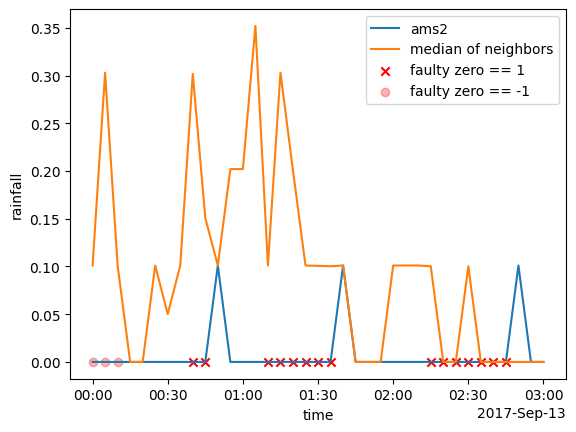

In [24]:
pws_id="ams2"

ds_pws.sel(id=pws_id).rainfall.plot(label="ams2")
ds_pws.sel(id=neighbor_ids_test).rainfall.median(dim="id").plot(label="median of neighbors")

plt.scatter(
    ds_pws.time.where(fz_array_test == 1),
    fz_array_test * 0,
    marker="x",
    c="r",
    label="faulty zero == 1",
)
plt.scatter(
    ds_pws.time.where(fz_array_test == -1),
   fz_array_test * 0,
    marker="o",
    c="r",
    alpha=0.3,
    label="faulty zero == -1",
)

plt.legend();

## testing for several stations

In [25]:
pws_data=ds_pws.rainfall
nbrs_not_nan=ds_pws.nbrs_not_nan
reference=ds_pws.reference
nint = 3

In [26]:
#initialize FOR WHOLE DATASET
sensor_array = np.zeros(np.shape(pws_data)) #or "empty"? 
ref_array = np.zeros(np.shape(pws_data))
fz_array = np.ones(np.shape(pws_data), dtype=np.float_) * -1

#create boolean arrays

#Wet timestep at each station WHAT ABOUT NANS?
sensor_array[np.where(pws_data > 0)] = 1

#Dry timestep at each station WHAT ABOUT NANS?
sensor_array[np.where(pws_data == 0)] = 0

#Wet timesteps of the reference 
ref_array[np.where(reference > 0)] = 1


In [28]:
#THIS CODE WORKSSSSS!!!!

for i in [0,1,2]: #np.arange(np.shape(pws_data)[0]):
    for a in np.arange(nint, np.shape(pws_data.time)[0]): #np.arange(nint, nint+200): 
        if sensor_array[i, a] > 0: 
            test1 += 1
            fz_array[i, a] = 0
        elif fz_array[i, a - 1] == 1: 
            test2 += 1
            fz_array[i, a] = 1
        elif (np.sum(sensor_array[i, a - nint : a + 1]) > 0) or (np.sum(ref_array[i, a - nint : a + 1]) < nint + 1):
            test3 += 1
            fz_array[i, a] = 0 
        else: 
            test4 += 1
            fz_array[i, a] = 1

In [32]:
np.shape(fz_array)


array([-1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])

In [31]:
#loop for several stations
yes1 = 0
yes2 = 0
yes3 = 0
yes4 = 0

for i in [0,1,2]: #np.arange(np.shape(pws_data)[0]):
    for j in np.arange(nint, np.shape(pws_data.time)[0]): 
        if sensor_array[i,j] > 0:
            yes1 += 1
            fz_array[i,j] = 0
        elif fz_array[i,j - 1] == 1: #detta inträffar aldrig
            yes2 += 1
            fz_array[i,j] = 1
        elif (np.sum(sensor_array[j - nint : j + 1]) > 0) or (np.sum(ref_array[j - nint : j + 1]) < nint + 1):
            yes3 += 1
            fz_array[i,j] = 0 
        else: #detta inträffar aldrig
            yes4 += 1
            fz_array[i,j] = 1

In [37]:
for a in np.arange(nint_test, np.shape(pws_data_test.time)[0]): #np.arange(nint, nint+200): 
    if sensor_array_test[a] > 0: 
        test1 += 1
        fz_array_test[a] = 0
    elif fz_array_test[a - 1] == 1: 
        test2 += 1
        fz_array_test[a] = 1
    elif (np.sum(sensor_array_test[a - nint_test : a + 1]) > 0) or (np.sum(ref_array_test[a - nint_test : a + 1]) < nint_test + 1):
        test3 += 1
        fz_array_test[a] = 0 
    else: 
        test4 += 1
        fz_array_test[a] = 1

0

In [67]:
fz_array[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

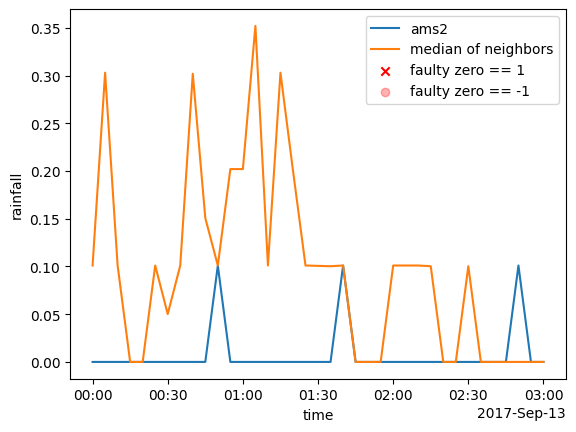

In [65]:
pws_id = "ams2"
ds_pws.sel(id=pws_id).rainfall.plot(label="ams2")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")

plt.scatter(
    ds_pws.time.where(fz_array[1,:] == 1),
    fz_array[1,:]  * 0,
    marker="x",
    c="r",
    label="faulty zero == 1",
)
plt.scatter(
    ds_pws.time.where(fz_array[1,:]  == -1),
   fz_array[1,:]  * 0,
    marker="o",
    c="r",
    alpha=0.3,
    label="faulty zero == -1",
)

plt.legend();

In [12]:
#should be added as data variable, not coordinate... 
ds_pws["fz_flag"] = fz_flag
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134, fz_flag: 219168)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
  * fz_flag    (fz_flag) float64 -1.0 -1.0 -1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    rainfall   (id, time) float32 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## With comments

In [ ]:
for i in np.arange(np.shape(pws_data)[0]):
    print(pws_data.isel(id = i).id)
    for j in np.arange(nint, np.shape(pws_data.time)[0]): 
        print(pws_data.isel(id = i, time =j).time.data)
        if sensor_array[i,j] > 0: 
            print('it is raining -> no flag')    
            fz_array[i,j] = 0
        elif fz_array[i,j - 1] == 1: 
            print('continue flagging')
            fz_array[i,j] = 1
        elif (np.sum(sensor_array[j - nint : j + 1]) > 0) or (np.sum(ref_array[j - nint : j + 1]) < nint + 1):
            print("it has been raining at the sensor last nint time steps OR it has NOT been raining at the nbrs the last nint timesteps")
            fz_array[i,j] = 0 
        else: 
            print("woops. flag!")
            fz_array[i,j] = 1